### @classmethod와 @staticmethod

In [1]:
# 첫번째 예시
# 접근 방법
class CustomClass:

    # instance method
    def add_instance_method(self, a,b):
        return a + b

    # classmethod
    @classmethod
    def add_class_method(cls, a, b):
        return a + b

    # staticmethod
    @staticmethod
    def add_static_method(a, b):
        return a + b

일반적인 경우
- 인스턴스 메소드안에 인스턴스 변수를 접근할 때, 첫 번째 인자에 객체 할당

In [4]:
CustomClass.add_instance_method(None, 3, 5)

8

classmethod에 접근

In [5]:
#일반적인경우처럼 호출하면 에러
CustomClass.add_class_method(CustomClass, 3, 5)

TypeError: add_class_method() takes 3 positional arguments but 4 were given

In [6]:
# 따로 cls부분에 정의 할 필요가 없음
CustomClass.add_class_method(3, 5)

8

staticmethod에 접근

In [7]:
CustomClass.add_static_method(3, 5)

8

classmethod도 staticmethod도 객체에서 접근 가능

In [8]:
a = CustomClass()
a.add_class_method(3, 5)
a.add_static_method(3, 5)

8

#### @classmethod와 @staticmethod 의 차이

In [10]:
class Language:
    default_language = "English"

    def __init__(self):
        self.show = '나의 언어는' + self.default_language

    @classmethod
    def class_my_language(cls):
        return cls()

    @staticmethod
    def static_my_language():
        return Language()

    def print_language(self):
        print(self.show)


class KoreanLanguage(Language):
    default_language = "한국어"

In [11]:
a = KoreanLanguage.static_my_language()
a.print_language()

나의 언어는English


In [12]:
b = KoreanLanguage.class_my_language()
b.print_language()

나의 언어는한국어


##### staticmethod에서는 부모클래스의 클래스속성 값을 가져오지만, classmethod에서는 cls인자를 활용하여 cls의 클래스속성을 가져오는 것을 알 수 있습니다.

------------------------------------------------------------------------

### MapReduce

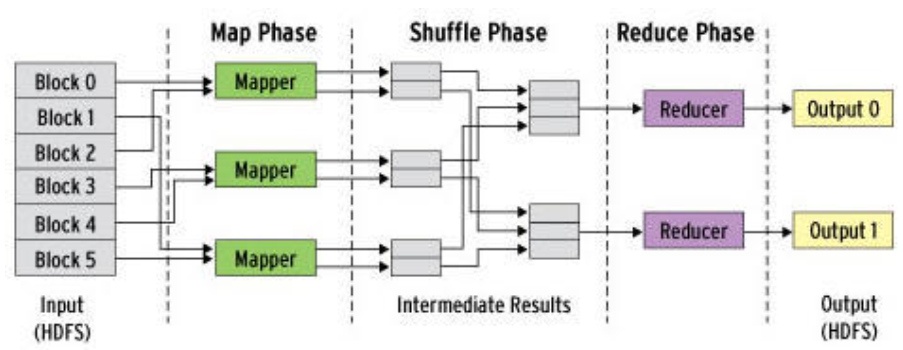

맵리듀스의 순서
- Split -> Map -> Shuffle -> Reduce

#### Map-Reduce 의 인풋/아웃풋

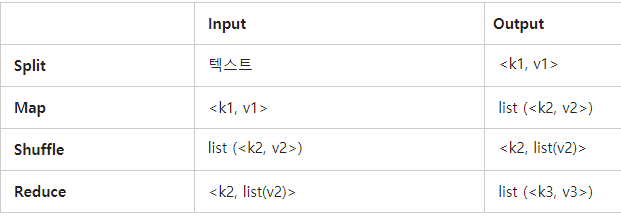

위 예시는 무슨 말 일까?
- ex
    - 한명의 박사가 a+b=?를 2000개를 계산하는 과정을 초등학생 5학년 200명이 계산 하는 느낌이다.
    - 병렬 계산

#### 단어 빈도수 세기 예시에서의 구조 흐름

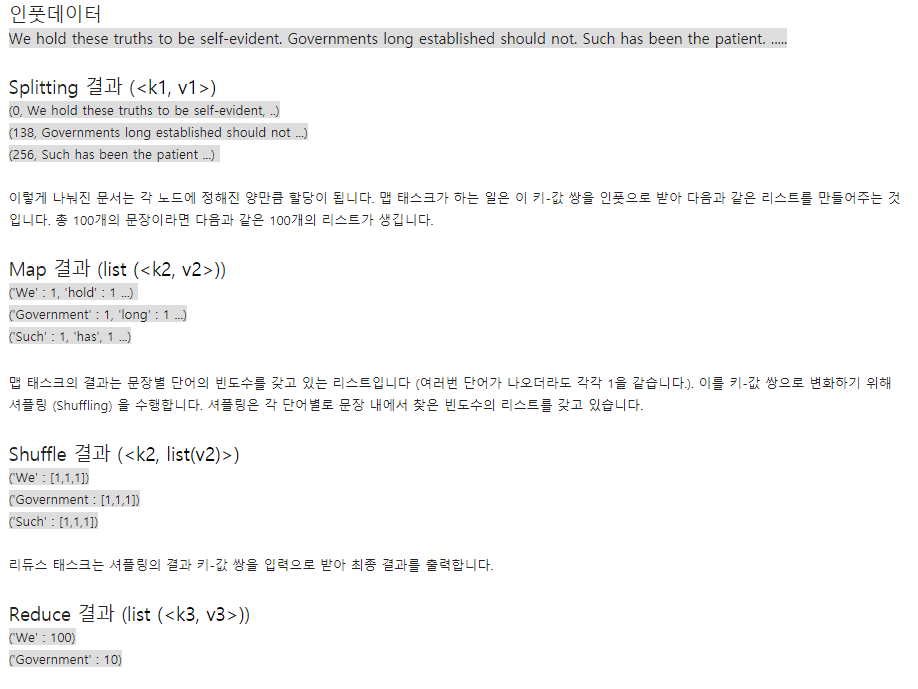

--------------------------------------------

제너릭하게 클래스 메서드로 맵리듀스를 사용하자

##### 클래스 메서드라는 아이디어를 맵리듀스에 사용했던 클래스에 적용해보자.
- 아래 코드는 inputData에 제너릭 @classmethod를 적용한 모습이다.
- @classmethod가 적용된 클래스 메서드는 공통 인터페이스를 통해 새로운 InputData 인스턴스를 생성한다.

In [25]:
import os
import random
class GenericInputData:
    def read(self):
        raise NotImplementedError

    @classmethod
    def generate_inputs(cls, config):
        raise NotImplementedError

In [19]:
class PathInputData(GenericInputData):
    def __init__(self, path):
        super().__init__()
        self.path = path

    def read(self):
        with open(self.path) as f:
            return f.read()

    @classmethod
    def generate_inputs(cls, config):
        data_dir = config['data_dir']
        for name in os.listdir(data_dir):
            yield cls(os.path.join(data_dir, name))#cls로 클래스 속성에 접근(genericinputData)

In [20]:
class GenericWorker:
    def __init__(self, input_data):
        self.input_data = input_data
        self.result = None

    def map(self):
        raise NotImplementedError

    def reduce(self, other):
        raise NotImplementedError

    @classmethod
    def create_workers(cls, input_class, config):
        workers = []
        for input_data in input_class.generate_inputs(config):
            workers.append(cls(input_data)) #map에 있는 카운트로 들어감
        return workers
    
    def create_workers(cls, PathInputData, {'data_dir': tmpdir}):
        workers = []
        for input_data in PathInputData.generate_inputs({'data_dir': tmpdir}):
            workers.append(cls(input_data))
        return workers

In [21]:
class LineCountWorker(GenericWorker):
    def map(self):
        data = self.input_data.read()
        self.result = data.count('\n')

    def reduce(self, other):
        self.result += other.result

In [27]:
from threading import Thread


def execute(workers):
    threads = [Thread(target=w.map) for w in workers] #thread는 코드를병렬로 작동하게 해준다.
    for thread in threads: thread.start()
    for thread in threads: thread.join()

    first, *rest = workers
    for worker in rest:
        first.reduce(worker)
    return first.result

In [ ]:
1 : 10
2 ; 20

In [22]:
def mapreduce(worker_class, input_class, config):
    workers = worker_class.create_workers(input_class, config)
    return execute(workers)


In [28]:
tmpdir = 'test_inputs'
config = {'data_dir': tmpdir}
result = mapreduce(LineCountWorker, PathInputData, config)
print(f'총 {result} 줄이 있습니다.')

총 4708 줄이 있습니다.
